# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.simplefilter('ignore')
from scipy import stats as st
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
from sklearn.utils import shuffle
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)



from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (StandardScaler)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
try :
    data_0  = pd.read_csv('/datasets/geo_data_0.csv')
    data_1  = pd.read_csv('/datasets/geo_data_1.csv')
    data_2  = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0  = pd.read_csv('geo_data_0.csv')
    data_1  = pd.read_csv('geo_data_1.csv')
    data_2  = pd.read_csv('geo_data_2.csv')
    display(data_0.head(10))
    display(data_1.head(10))
    display(data_2.head(10))                      


In [3]:
#функция для получения общей информации о датафрейме
def df_inf(data): 
    display(data.head())
    display(data.describe(include='all').T)
    display(data.info())
    for column in data.columns:
        display()
        display(column)
        display(data[column].unique())
    display(data[data.duplicated()])
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm') )

In [4]:
df_inf(data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99990,bxg6G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.500419,0.871832,-1.408605,-0.07258,0.50236,1.073581,2.362331
f1,100000.0,NaN,NaN,NaN,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,NaN,NaN,NaN,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.00379
product,100000.0,NaN,NaN,NaN,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'id'

array(['txEyH', '2acmU', '409Wp', ..., '3rnvd', '7kl59', '1CWhH'],
      dtype=object)

'f0'

array([0.70574498, 1.33471129, 1.02273226, ..., 1.02958465, 0.99816289,
       1.76475393])

'f1'

array([-0.4978225 , -0.34016425,  0.15199044, ...,  0.01878693,
       -0.52858167, -0.26641676])

'f2'

array([ 1.22116995,  4.36508033,  1.41992624, ..., -1.34830814,
        1.58386866,  5.72284937])

'product'

array([105.28006184,  73.03775027,  85.26564713, ...,  64.37544259,
        74.04076435, 149.63324561])

,id,f0,f1,f2,product


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


In [5]:
data_0[data_0['id'].duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [6]:
data_1[data_0['id'].duplicated()]

,id,f0,f1,f2,product
7530,9MMvV,8.391597,4.135990,1.005425,26.953261
41724,4dJt2,9.275227,-7.810681,1.999934,53.906522
51970,cuvVK,9.513402,-8.803552,0.011952,0.000000
63593,fBC4y,0.009013,1.112960,3.996426,110.992147
66136,KK7UR,8.306984,-0.338676,5.000386,134.766305
69163,Qk6xL,18.545841,-7.219445,2.001204,53.906522
75715,AQema,23.131906,-0.551261,4.003394,107.813044
90815,mPEhE,10.231390,-12.954775,1.993775,53.906522
92341,A5BwN,-9.043047,-5.562453,0.000657,3.179103
97785,le3wh,-5.323811,-5.735230,0.004351,3.179103


In [7]:
data_0.query('id=="HZww2"')

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


Обнаружены скважины с одинаковыми id но цифры отличаются так что не удаляем

In [8]:
df_inf(data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,wt4Uk,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,NaN,NaN,NaN,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,NaN,NaN,NaN,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,NaN,NaN,NaN,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'id'

array(['kBEdx', '62mP7', 'vyE1P', ..., '09gWa', 'rqwUm', 'relB0'],
      dtype=object)

'f0'

array([-15.00134818,  14.27208781,   6.26318735, ...,  -7.37889139,
         0.66571381,  -3.42613898])

'f1'

array([-8.27599995, -3.47508322, -5.94838579, ..., -3.08410387,
       -6.15259286, -7.7942742 ])

'f2'

array([-5.87601369e-03,  9.99182737e-01,  5.00116016e+00, ...,
        4.99865060e+00,  1.00014635e+00, -3.29851829e-03])

'product'

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

,id,f0,f1,f2,product


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


In [9]:
df_inf(data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,xCHr8,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,NaN,NaN,NaN,-0.002081,1.730417,-7.08402,-1.17482,-0.009482,1.163678,7.844801
f2,100000.0,NaN,NaN,NaN,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,NaN,NaN,NaN,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'id'

array(['fwXo0', 'WJtFt', 'ovLUW', ..., 'tKPY3', 'nmxp2', 'V9kWn'],
      dtype=object)

'f0'

array([-1.1469871 ,  0.2627779 ,  0.19458728, ..., -1.19993432,
       -2.41989641, -2.55142066])

'f1'

array([ 0.96332792,  0.26983896,  0.289035  , ..., -2.95763723,
        2.41722066, -2.02562514])

'f2'

array([-0.82896492, -2.53018652, -5.58643277, ...,  5.219411  ,
       -5.54844392,  6.09089066])

'product'

array([ 27.75867323,  56.06969663,  62.87191005, ..., 157.08007975,
        51.79525299, 102.77576749])

,id,f0,f1,f2,product


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


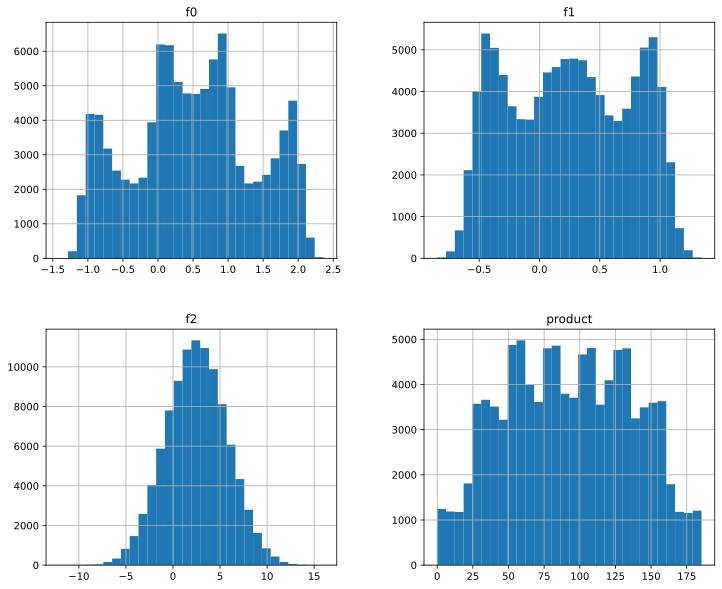

In [10]:
data_0.hist(figsize=(12,10),bins=30);

В первом регионе види странное распределение признака f0 f1 , как будто в регионе сущевсвует 4 разных группы с связанными зависимостями и их объеденили .Причем признак ф3 распределен нормально

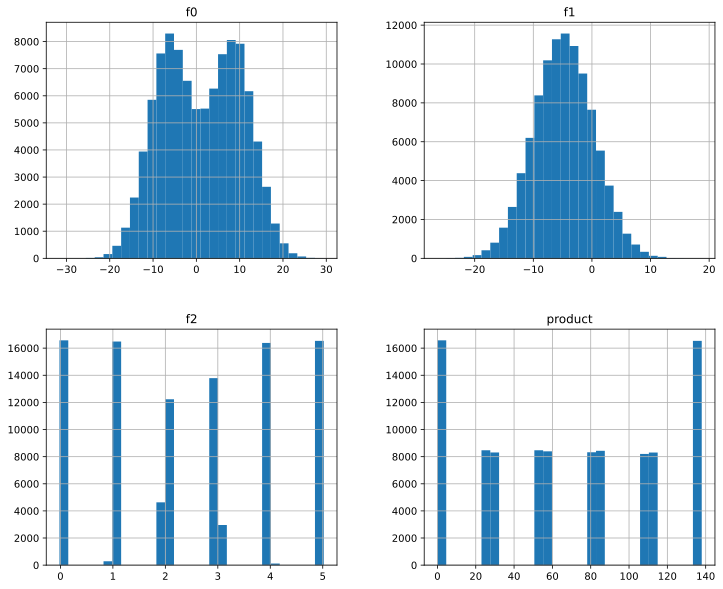

In [11]:
data_1.hist(figsize=(12,10),bins=30);

в втором регионе  признак ф1  распределен как будто там соеденены две группы , признак ф2 продакт аспределеныеще более странно 
  распределены еще более странно как будто данные синтетические . Кроме того в этом регионе много пустых месторождений и много очень богатых местророждений 
  в третьем регионе распределение больше походит на нормальное

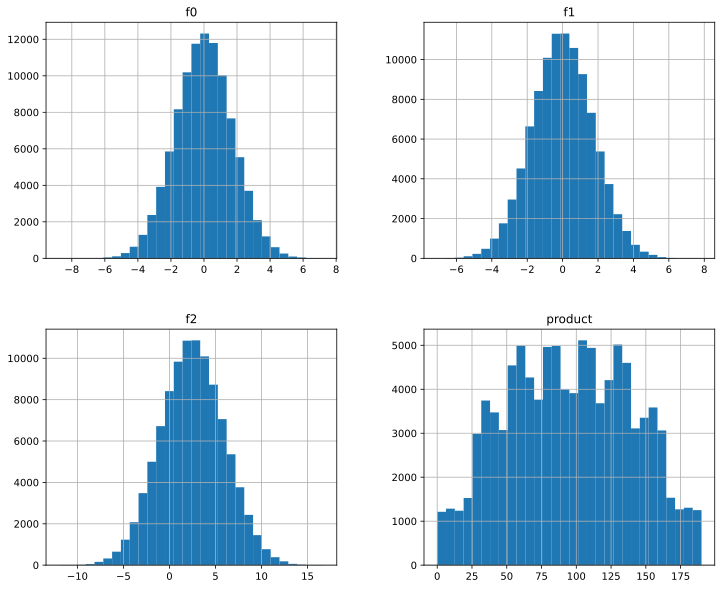

In [12]:
data_2.hist(figsize=(12,10),bins=30);

In [13]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [14]:
data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [15]:
#sns.pairplot(data_0.drop('id'));

In [16]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [17]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [18]:
RANDOM=12345
def split_data(features, target):
    (features_train,
     features_valid,
     target_train,
     target_valid) = train_test_split(features,
                                      target,
                                      test_size = 0.25,
                                      random_state = RANDOM)
   
    return (features_train,
            features_valid,
            
            target_train,
            target_valid,
            )

In [19]:
features_0 = data_0.drop(['id','product'] , axis=1)
target_0 = data_0['product']

In [20]:
features_0

,f0,f1,f2
0,0.705745,-0.497823,1.221170
1,1.334711,-0.340164,4.365080
2,1.022732,0.151990,1.419926
3,-0.032172,0.139033,2.978566
4,1.988431,0.155413,4.751769
...,...,...,...
99995,0.971957,0.370953,6.075346
99996,1.392429,-0.382606,1.273912
99997,1.029585,0.018787,-1.348308
99998,0.998163,-0.528582,1.583869


In [21]:
features_1 = data_1.drop(['id','product'] , axis=1)
target_1 = data_1['product']

In [22]:
features_2 = data_2.drop(['id','product'] , axis=1)
target_2 = data_2['product']

In [23]:
(features_train_0,
 features_valid_0,
 target_train_0,
 target_valid_0)=split_data(features_0,target_0)

In [24]:
features_train_0.shape

(75000, 3)

In [25]:
(features_train_1,
            features_valid_1,
            
            target_train_1,
            target_valid_1,
            )=split_data(features_1,target_1)

In [26]:
features_train_1.shape

(75000, 3)

In [27]:
(features_train_2,
            features_valid_2,
            
            target_train_2,
            target_valid_2,
            )=split_data(features_2,target_2)

In [28]:
features_train_2.shape

(75000, 3)

Вывод: данные были загружены и изучены, и разбиты на целевые признаки и признаки. Пропусков и дубликатов не обнаружено. Выявлены зависимости в данных целевого значения от признаков. зависимость значительно только с f2 признаком. В втором регионе эта зависимость достигает 99 процентов. В остальных регионах зависимость меньше. Также выявлены странные распределения призкаков во втором регионе. Данные похожи на синтетические 

## Обучение и проверка модели

In [29]:
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, prediction))

In [30]:
scaler = StandardScaler()
scaler.fit(features_train_0)
features_train_0 = pd.DataFrame(scaler.transform(features_train_0))
features_valid_0 = pd.DataFrame(scaler.transform(features_valid_0))

scaler = StandardScaler()
scaler.fit(features_train_1)
features_train_1 = pd.DataFrame(scaler.transform(features_train_1))
features_valid_1 = pd.DataFrame(scaler.transform(features_valid_1))

scaler = StandardScaler()
scaler.fit(features_train_2)
features_train_2 = pd.DataFrame(scaler.transform(features_train_2))
features_valid_2 = pd.DataFrame(scaler.transform(features_valid_2))

In [31]:
model = LinearRegression( )
model.fit(features_train_0, target_train_0)
predicted_valid_0=model.predict(features_valid_0)




mse = mean_squared_error(predicted_valid_0, target_valid_0) 
print("RMSE: {}".format(np.sqrt(mse)))
print('Средний запас предсказанного сырья',predicted_valid_0.mean())

RMSE: 37.5794217150813
Средний запас предсказанного сырья 92.59256778438035


Видим что средняя ошибка значительная , до трети от среднего запаса

In [32]:
param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3],"loss":["squared_loss" ,"huber" , "epsilon_insensitive"],"penalty":["l2","l1","elasticnet"]} 

linear_regression_model = SGDRegressor(tol=.001)
n_iter_search = 8 
random_search = RandomizedSearchCV(linear_regression_model, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search, 
                                   cv=3, 
                                   scoring='neg_mean_squared_error',
                                      ) 
random_search.fit(features_train_0, target_train_0) 

print("Лучшие параметры: {}".format(random_search.best_params_)) 
print("Лучшая оценка MSE: {}".format(random_search.best_score_))


Лучшие параметры: {'penalty': 'l2', 'loss': 'squared_loss', 'eta0': 0.003}
Лучшая оценка MSE: -1424.1178451279377


попробовал перебрать параметры для определения более эффективных гиперпараметров, но результат не практически не  изменился 

In [33]:
model = LinearRegression( )
model.fit(features_train_1, target_train_1)
predicted_valid_1=model.predict(features_valid_1)

from sklearn.metrics import mean_absolute_error
rmse = mean_squared_error(predicted_valid_1, target_valid_1, squared=False) 
print("RMSE: {}".format(rmse))
print('Средний запас предсказанного сырья',predicted_valid_1.mean())

RMSE: 0.893099286775617
Средний запас предсказанного сырья 68.728546895446


Среднеквадратическая ошибка минимальна, то есть модель предсказывает результаты с высокой точностью

In [34]:
model = LinearRegression( )
model.fit(features_train_2, target_train_2)
predicted_valid_2=model.predict(features_valid_2)

from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(predicted_valid_2, target_valid_0, squared=False) 
print("RMSE: {}".format(rmse))
print('Средний запас предсказанного сырья',predicted_valid_2.mean())

RMSE: 48.671457760870574
Средний запас предсказанного сырья 94.96504596800489


Средняя квадратическая ошибка еще больше чем у первой модели, что показывает невысокую эффективность предсказаний

In [35]:
probabilities_0=pd.Series(data=predicted_valid_0,index=target_valid_0.index)
probabilities_1=pd.Series(data=predicted_valid_1,index=target_valid_1.index)
probabilities_2=pd.Series(data=predicted_valid_2,index=target_valid_2.index)

Вывод:
Таким образом были обучены модели для трех регионов добычи, модели в 1 и 3 регионе обладают низкой точностью, модель второго региона напротив показала высокую точность Как и следовало ожидать так как на этапе изучения данных была видна практически стопроцентная корреляция f2 признака с уровнем запасов в месторождении.


## Подготовка к расчёту прибыли

In [36]:
Budget = 1e+07 # расходы на скважины в тысячах рублей 
Chosen_well_number = 500
Price_per_barrel = 450
Best_well_number=200

In [37]:

def revenue(target,probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return Price_per_barrel * selected.sum() - Budget


In [38]:
nul_revenue=Budget/Best_well_number/Price_per_barrel
print(nul_revenue)

111.11111111111111


сколько нужно добывать 1 скважине для безубыточности

In [39]:
reg_0_mean  =target_0.mean()
reg_1_mean  =target_1.mean()
reg_2_mean  =target_2.mean()
print('Средняя добыча 1-ого региона',round(reg_0_mean))
print('Средняя добыча 2-ого региона',round(reg_1_mean))
print('Средняя добыча 3-его региона',round(reg_2_mean))

Средняя добыча 1-ого региона 93
Средняя добыча 2-ого региона 69
Средняя добыча 3-его региона 95


Вывод.

Как видим средний запас нефти в скважине в каждом регионе меньше чем необходимое для получения безубыточности , то есть без модели с высокой точностью высока вероятность получения убытков в этих регионах

## Расчёт прибыли и рисков 

In [40]:
print('Прибыль в случае выбора наилучших месторождений',revenue(target_valid_0,probabilities_0, Best_well_number))


Прибыль в случае выбора наилучших месторождений 3320826.0431398507


Видим что наибольшую прибыль получили бы с 1 региона если бы выбрали лучшие месторождения

In [41]:
print('Прибыль в случае выбора наилучших месторождений',revenue(target_valid_1,probabilities_1, Best_well_number))

Прибыль в случае выбора наилучших месторождений 2415086.6966815125


In [42]:
print('Прибыль в случае выбора наилучших месторождений',revenue(target_valid_2,probabilities_2, Best_well_number))

Прибыль в случае выбора наилучших месторождений 2710349.9635998327


In [43]:
state = np.random.RandomState(12345)
def bootstrap_1000(target, probs):    
    values = []
    for i in range(1000):
        # < напишите код здесь>
        target_subsample = target.sample(replace=True,n=Chosen_well_number,random_state=state)
        probabilities=probs[target_subsample.index]    
        v=revenue(target_subsample, probabilities,Best_well_number)
        values.append(v)   
    

    values = pd.Series(values)
    lower = values.quantile(0.025)# < напишите код здесь>
    upper = values.quantile(0.975)
    mean = values.mean()
    return values,lower,upper,mean


In [44]:
values_0,lower_0,upper_0,mean_0= bootstrap_1000(target_valid_0,probabilities_0)
print('95% доверительный интервал равен''[',lower_0,";",upper_0,']')

print('среднее выборок',mean_0)

95% доверительный интервал равен[ -102090.09483793723 ; 947976.353358369 ]
среднее выборок 425938.5269105924


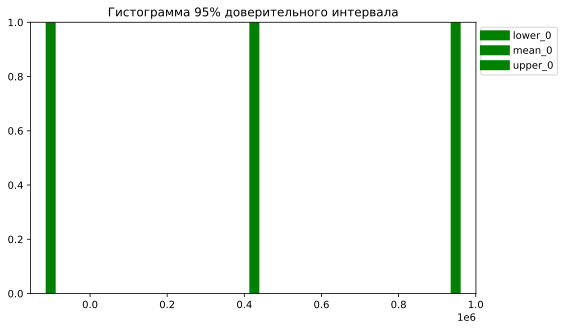

In [45]:
xcoords = [lower_0, mean_0, upper_0]

g=['lower_0', 'mean_0', 'upper_0']
for xc,m in zip(xcoords,g):
    plt.axvline(x=xc, color='g',label=m,linewidth=10)
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.title('Гистограмма 95% доверительного интервала');

In [46]:
values_1,lower_1,upper_1,mean_1= bootstrap_1000(target_valid_1,probabilities_1)
print('95% доверительный интервал равен''[',lower_1,";",upper_1,']')
print('среднее выборок',mean_1)

95% доверительный интервал равен[ 128123.23143308419 ; 953612.9820669085 ]
среднее выборок 518259.4936973249


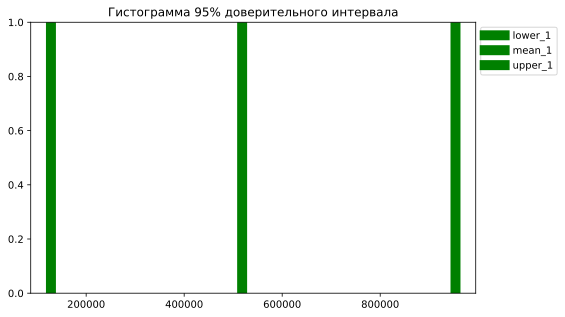

In [47]:
xcoords = [lower_1, mean_1, upper_1]

g=['lower_1', 'mean_1', 'upper_1']
for xc,m in zip(xcoords,g):
    plt.axvline(x=xc, color='g',label=m,linewidth=10)
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.title('Гистограмма 95% доверительного интервала');

+------------------------+-------------------+
|       Показатель       |      Значение     |
+------------------------+-------------------+
|    Средняя выручка     |     430.3 млн     |
|          Риск          |        4.9%       |
| Доверительный интервал | -93.6 : 974.2 млн |
+------------------------+-------------------+


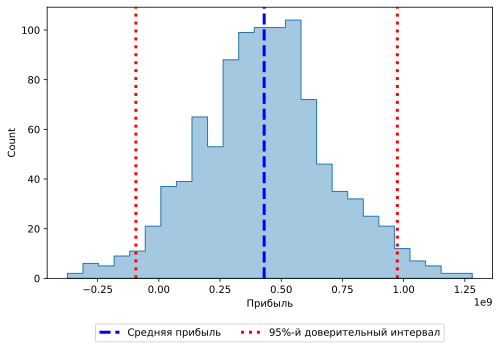

In [48]:
!pip3 install prettytable
from prettytable import PrettyTable
import seaborn as sns
from scipy import stats as st

BUDGET = 10000000000
BARREL_COST = 450
BARRELS_IN_UNIT = 1000
UNIT_COST = BARREL_COST * BARRELS_IN_UNIT
TOTAL_POINTS = 500
POINTS = 200

def revenue_2(target, predictions, points, budget, unit_cost):
    predicted_sorted = predictions.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:points]
    return selected.sum() * unit_cost - budget

def bootstrap_2(target, probabilities):
    state = np.random.RandomState(888)
    values=[]
    for i in range(1000):
        target_subsample = target.sample(replace=True,\
            random_state=state, n=TOTAL_POINTS)

        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue_2(target_subsample, probs_subsample, POINTS, BUDGET, UNIT_COST))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = st.percentileofscore(values, 0)

     # Отображение таблицы
    table = PrettyTable()
    table.field_names = ['Показатель', 'Значение']
    table.add_row(['Средняя выручка', f'{mean/1e6:.1f} млн'])
    table.add_row(['Риск', f'{risk:.2}%'])
    table.add_row(['Доверительный интервал', f'{lower/1e6:.1f} : {upper/1e6:.1f} млн'])
    print(table)

    sns.histplot(values, alpha=0.4,  element="step")
    plt.xlabel('Прибыль')
    plt.axvline(x=mean, color='b', ls='--', lw=3, label='Средняя прибыль')
    plt.axvline(x=lower, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper, color='r', ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()

bootstrap_2(target_valid_2,probabilities_2)

In [49]:
values_2,lower_2,upper_2,mean_2= bootstrap_1000(target_valid_2,probabilities_2)
print('95% доверительный интервал равен''[',lower_2,";",upper_2,']')
print('среднее выборок',mean_2)

95% доверительный интервал равен[ -115852.60916001163 ; 989629.9398445741 ]
среднее выборок 420194.00534405006


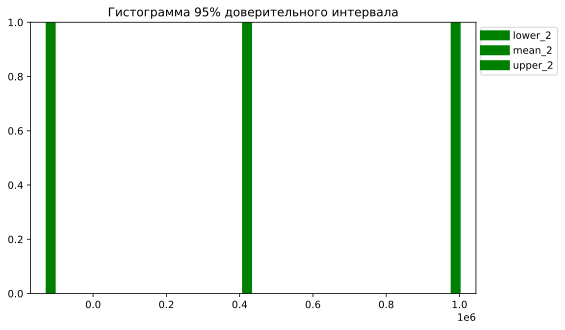

In [50]:
xcoords = [lower_2, mean_2, upper_2]

g=['lower_2', 'mean_2', 'upper_2']
for xc,m in zip(xcoords,g):
    plt.axvline(x=xc, color='g',label=m,linewidth=10)
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.title('Гистограмма 95% доверительного интервала');

Посчитаем вероятности получения прибыли в регионах

In [51]:
print('вероятность получения убытка в 1 регионе',len(values_0[values_0<0])/len(values_0))

вероятность получения убытка в 1 регионе 0.06


In [52]:
print('вероятность получения убытка в 2 регионе',len(values_1[values_1<0])/len(values_1))

вероятность получения убытка в 2 регионе 0.003


In [53]:
print('вероятность получения убытка в 3 регионе',len(values_2[values_2<0])/len(values_2))

вероятность получения убытка в 3 регионе 0.062


Вывод :

Проанализировав показатели прибыльности и вероятности убытков можно заключить что наиболее выгодный для разработки и проходящий по требованиям вероятности убытков это второй регион. Так как прибыль в нем была даже в самых неудачных выборках, средняя прибыль по выборкам наиболее высокая , а также модель наиболее верно предсказывает возможную прибыль от месторождений, что позволяет выбрать наиболее выгодные месторождения из разведанных.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован